### The idea here is

In [78]:
# --- CVAE v1 (fixed) ---
# Fixes:
# 1) Separate vocab sizes for start_zone vs end_zone (sz != ez)
# 2) term loss only on END timesteps
# 3) Encoder ignores padding via pack_padded_sequence
# 4) Correct import order + minor cleanup

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence


class PossessionDataset(Dataset):
    def __init__(self, seq_ids, cond_vecs, zone_code, minute_code, T: int):
        self.seqs = seq_ids
        self.cond = torch.as_tensor(cond_vecs, dtype=torch.float32)  # Cz [N,12]
        self.zone = torch.as_tensor(zone_code, dtype=torch.long)     # [N]
        self.minb = torch.as_tensor(minute_code, dtype=torch.long)   # [N]
        self.T = int(T)

    def __len__(self):
        return len(self.seqs)

    def __getitem__(self, i):
        s = self.seqs[i]

        def pad(x, pad_id=0):
            x = x[: self.T]
            if len(x) < self.T:
                x = x + [pad_id] * (self.T - len(x))
            return torch.tensor(x, dtype=torch.long)
        
        def pad_u(u):
            u = u[: self.T]
            if len(u) < self.T:
                u = u + [[0.0, 0.0]] * (self.T - len(u))
            return torch.tensor(u, dtype=torch.float32)  # [T,2]
        
        role_ids = pad(s["role"], 0)
        type_ids = pad(s["type"], 0)
        sz_ids   = pad(s["sz"],   0)
        ez_ids   = pad(s["ez"],   0)
        out_ids  = pad(s["out"],  0)
        dt_ids   = pad(s["dt"],   0)
        term_ids = pad(s["term"], 0)

        u_end_t  = pad_u(s["u_end"]) 

        mask = (type_ids != 0).float()
        length = int(mask.sum().item())

        
        x = torch.stack([role_ids, type_ids, sz_ids, ez_ids, out_ids, dt_ids, term_ids], dim=-1)

        # NEW: also return zone/minute context codes
        return x, u_end_t, self.cond[i], self.zone[i], self.minb[i], mask, length


def masked_ce(logits: torch.Tensor, target: torch.Tensor, mask: torch.Tensor) -> torch.Tensor:
    """
    logits: [B,T,V], target: [B,T], mask: [B,T] in {0,1}
    """
    B, T, V = logits.shape
    loss = F.cross_entropy(logits.reshape(B * T, V), target.reshape(B * T), reduction="none")
    loss = loss.reshape(B, T) * mask
    return loss.sum() / (mask.sum() + 1e-8)


def kld(mu: torch.Tensor, logv: torch.Tensor) -> torch.Tensor:
    return -0.5 * torch.mean(1 + logv - mu.pow(2) - logv.exp())


class SeqCVAE(nn.Module):
    def __init__(
        self,
        n_types: int,
        n_sz: int,
        n_ez: int,
        n_out: int,
        n_dt: int,
        n_term: int,
        n_zones: int,        # NEW
        n_minbins: int,  
        n_role: int,
        emb: int = 32,
        hidden: int = 256,
        zdim: int = 32,
        cdim: int = 12,
        uemb: int = 16,
        zone_emb_dim: int = 8,                 
        min_emb_dim: int = 4,                  
    ):

        super().__init__()
        self.cdim = cdim
        self.zdim = zdim
        self.uemb = uemb

        # embeddings
        self.type_emb = nn.Embedding(n_types, emb, padding_idx=0)
        self.sz_emb   = nn.Embedding(n_sz,   emb, padding_idx=0)
        self.ez_emb   = nn.Embedding(n_ez,   emb, padding_idx=0)
        self.out_emb  = nn.Embedding(n_out,  emb, padding_idx=0)
        self.dt_emb   = nn.Embedding(n_dt,   emb, padding_idx=0)
        self.term_emb = nn.Embedding(n_term, emb, padding_idx=0)
        self.zone_ctx_emb = nn.Embedding(n_zones, zone_emb_dim)
        self.min_ctx_emb  = nn.Embedding(n_minbins, min_emb_dim)
        self.role_emb = nn.Embedding(n_role, emb, padding_idx=0)

        self.c_eff_dim = cdim + zone_emb_dim + min_emb_dim  
        

        self.c_eff_dim = cdim + zone_emb_dim + min_emb_dim
        self.u_end_emb = nn.Linear(2, uemb)

        in_dim = emb * 7 + uemb

        # encoder (packed)
        self.enc_rnn = nn.GRU(in_dim + self.c_eff_dim, hidden, batch_first=True)
        self.to_mu   = nn.Linear(hidden, zdim)
        self.to_logv = nn.Linear(hidden, zdim)

        # decoder (teacher forcing, un-packed is fine)
        self.dec_rnn = nn.GRU(in_dim + self.c_eff_dim + zdim, hidden, batch_first=True)

        # heads
        self.h_u_end = nn.Sequential(
            nn.Linear(hidden, hidden//2),
            nn.ReLU(),
            nn.Linear(hidden//2, 4),
        )
        self.h_type = nn.Linear(hidden, n_types)
        self.h_sz   = nn.Linear(hidden, n_sz)
        self.h_ez   = nn.Linear(hidden, n_ez)
        self.h_out  = nn.Linear(hidden, n_out)
        self.h_dt   = nn.Linear(hidden, n_dt)
        self.h_term = nn.Linear(hidden, n_term)
        self.h_role = nn.Linear(hidden, n_role)

    def embed_step(self, x: torch.Tensor, u_end_in: torch.Tensor) -> torch.Tensor:
        # x: [B,T,6]
        role, t, sz, ez, out, dt, term = x.unbind(dim=-1)
        tok_emb = torch.cat(
            [
                self.role_emb(role),
                self.type_emb(t),
                self.sz_emb(sz),
                self.ez_emb(ez),
                self.out_emb(out),
                self.dt_emb(dt),
                self.term_emb(term),
            ],
            dim=-1,
        )

        u_emb = self.u_end_emb(u_end_in)  # [B,T,uemb]
        return torch.cat([tok_emb, u_emb], dim=-1)
    def make_cond(self, c: torch.Tensor, zone_code: torch.Tensor, min_code: torch.Tensor):
        # c: [B, cdim], zone_code/min_code: [B]
        zemb = self.zone_ctx_emb(zone_code)
        memb = self.min_ctx_emb(min_code)
        return torch.cat([c, zemb, memb], dim=-1)  # [B, c_eff_dim]

    def encode(self, x: torch.Tensor, c: torch.Tensor,u_end:torch.Tensor, lengths: torch.Tensor):
        """
        lengths: [B] int, number of non-pad timesteps (>=1)
        """
        B, T, _ = x.shape
        e = self.embed_step(x,u_end)
        cond_rep = c.unsqueeze(1).expand(B, T, c.shape[-1])
        inp = torch.cat([e, cond_rep], dim=-1)

        lengths_cpu = lengths.detach().to("cpu")
        packed = pack_padded_sequence(inp, lengths_cpu, batch_first=True, enforce_sorted=False)
        _, h = self.enc_rnn(packed)
        h = h.squeeze(0)

        mu = self.to_mu(h)
        logv = self.to_logv(h)
        return mu, logv

    def reparam(self, mu: torch.Tensor, logv: torch.Tensor) -> torch.Tensor:
        std = torch.exp(0.5 * logv)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, x_in: torch.Tensor, z: torch.Tensor,u_end:torch.Tensor, cond: torch.Tensor):
        B, T, _ = x_in.shape
        e = self.embed_step(x_in, u_end)
        cond_rep = cond.unsqueeze(1).expand(B, T, cond.shape[-1])
        z_rep = z.unsqueeze(1).expand(B, T, z.shape[-1])
        inp = torch.cat([e, cond_rep, z_rep], dim=-1)
        out, _ = self.dec_rnn(inp)
        return {
            "role": self.h_role(out),
            "type": self.h_type(out),
            "sz":   self.h_sz(out),
            "ez":   self.h_ez(out),
            "out":  self.h_out(out),
            "dt":   self.h_dt(out),
            "term": self.h_term(out),

            "u_end_raw": self.h_u_end(out), 
        }

    def forward(self, x, c, zone_code, min_code,u_end, lengths):
        cond = self.make_cond(c, zone_code, min_code)
        mu, logv = self.encode(x, cond,u_end, lengths)
        z = self.reparam(mu, logv)

        x_in = x.clone()
        x_in[:, 1:] = x[:, :-1]
        x_in[:, 0] = 0

        u_in = u_end.clone()
        u_in[:, 1:] = u_end[:, :-1]
        u_in[:, 0] = 0.0

        logits = self.decode(x_in, z,u_in, cond)
        return logits, mu, logv

def masked_l1(pred: torch.Tensor, target: torch.Tensor, mask: torch.Tensor) -> torch.Tensor:
    # pred/target: [B,T,2], mask: [B,T] in {0,1}
    loss = F.smooth_l1_loss(pred, target, reduction="none").sum(dim=-1)  # [B,T]
    loss = loss * mask
    return loss.sum() / (mask.sum() + 1e-8)

def masked_beta_nll(u_true, ax, bx, ay, by, mask, eps=1e-4):
    # u_true: [B,T,2] in [0,1]
    ux = u_true[...,0].clamp(eps, 1-eps)
    uy = u_true[...,1].clamp(eps, 1-eps)

    # log Beta PDF per dim:
    # log p(u) = (a-1)log u + (b-1)log(1-u) - (lgamma(a)+lgamma(b)-lgamma(a+b))
    logBx = torch.lgamma(ax) + torch.lgamma(bx) - torch.lgamma(ax + bx)
    logBy = torch.lgamma(ay) + torch.lgamma(by) - torch.lgamma(ay + by)

    logpx = (ax-1)*torch.log(ux) + (bx-1)*torch.log(1-ux) - logBx
    logpy = (ay-1)*torch.log(uy) + (by-1)*torch.log(1-uy) - logBy

    nll = -(logpx + logpy)  # [B,T]
    nll = nll * mask
    return nll.sum() / (mask.sum() + 1e-8)
def compute_loss(
    logits: dict,
    x: torch.Tensor,
    u_end_t: torch.Tensor,          # NEW [B,T,2] floats
    mask: torch.Tensor,
    type_end_id: int,
    type_pass_id: int,              # NEW
    type_carry_id: int,             # NEW
    mu: torch.Tensor,
    logv: torch.Tensor,
    beta: float = 1.0,
    lambda_u: float = 0.1,          # NEW weight
):
    role_t, type_t, sz_t, ez_t, out_t, dt_t, term_t = x.unbind(dim=-1)

    loss_main = (
        masked_ce(logits["role"], role_t, mask) +
        masked_ce(logits["type"], type_t, mask) +
        masked_ce(logits["sz"],   sz_t,   mask) +
        masked_ce(logits["ez"],   ez_t,   mask) +
        masked_ce(logits["out"],  out_t,  mask) +
        masked_ce(logits["dt"],   dt_t,   mask)
    )

    end_mask = (type_t == type_end_id).float() * mask
    loss_term = masked_ce(logits["term"], term_t, end_mask) if end_mask.sum() > 0 else torch.tensor(0.0, device=x.device)

    # --- NEW: u_end regression (only for Pass/Carry timesteps) ---
    u_mask = ((type_t == type_pass_id) | (type_t == type_carry_id)).float() * mask  # [B,T]



    # model outputs raw -> squash to [0,1]
    raw = logits["u_end_raw"]              # [B,T,4]
    # ensure alpha,beta > 1 (stable, unimodal-ish) by softplus + 1
    ab = (F.softplus(raw) + 1.0).clamp(max=50.0)
    ax, bx, ay, by = ab[...,0], ab[...,1], ab[...,2], ab[...,3]
    

    loss_u = masked_beta_nll(u_end_t, ax, bx, ay, by, u_mask) if u_mask.sum() > 0 else torch.tensor(0.0, device=x.device)#! U BASED SWITCH TO X Y !!!!

    loss_kld = kld(mu, logv)

    total = loss_main + loss_term + lambda_u * loss_u + beta * loss_kld
    return total, {"main": loss_main.detach(), "term": loss_term.detach(), "u": loss_u.detach(), "kld": loss_kld.detach()}
# --- Example training loop skeleton (minimal) ---
from tqdm import tqdm

def train_one_epoch(model, loader, optimizer, device, type2id, beta, lambda_u=0.1):
    model.train()
    END_ID = type2id["END"]
    PASS_ID  = type2id["Pass"]
    CARRY_ID = type2id["Carry"]

    running = 0.0

    pbar = tqdm(loader, desc=f"train beta={beta:.2f}", leave=False)
    for x, u_end_t,c, zc, mc, mask, lengths in pbar:
        x = x.to(device)
        u_end_t = u_end_t.to(device)  
        c = c.to(device)
        zc = zc.to(device)
        mc = mc.to(device)
        mask = mask.to(device)
        lengths = lengths.to(device)

        logits, mu, logv = model(x, c, zc, mc, u_end_t, lengths)
        loss, parts = compute_loss(
            logits=logits,
            x=x,
            u_end_t=u_end_t,
            mask=mask,
            type_end_id=END_ID,
            type_pass_id=PASS_ID,
            type_carry_id=CARRY_ID,
            mu=mu,
            logv=logv,
            beta=beta,
            lambda_u=lambda_u,
        )

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        running += loss.item()
        pbar.set_postfix(loss=loss.item(), main=float(parts["main"]),u=float(parts["u"]),kld=float(parts["kld"]))

    return running / max(1, len(loader))



In [2]:
#Even larger loader
import json
from pathlib import Path
import pandas as pd
import numpy as np


def _safe_id(x):
    if isinstance(x, dict) and "id" in x:
        return x["id"]
    return np.nan

def _safe_name(x):
    if isinstance(x, dict) and "name" in x:
        return x["name"]
    return None

def _safe_bool(e: dict, key: str, default=False) -> bool:
    v = e.get(key, default)
    return bool(v) if v is not None else bool(default)


def _generic_outcome_for_event(e: dict):
    """
    Returns (outcome_name, success_bool_or_nan) using StatsBomb conventions.
    - Many nested outcome fields exist; missing often implies 'Complete/Success'.
    - For event types without a notion of outcome, returns (None, np.nan).
    """
    t = _safe_name(e.get("type"))

    # PASS
    if t == "Pass" and isinstance(e.get("pass"), dict):
        out = e["pass"].get("outcome")
        if isinstance(out, dict):
            return out.get("name"), False
        # missing outcome => completed
        return "Complete", True

    # SHOT
    if t == "Shot" and isinstance(e.get("shot"), dict):
        out = e["shot"].get("outcome")
        if isinstance(out, dict):
            # success is ambiguous (goal vs on target etc). keep np.nan for boolean.
            return out.get("name"), np.nan
        return None, np.nan

    # DRIBBLE
    if t == "Dribble" and isinstance(e.get("dribble"), dict):
        out = e["dribble"].get("outcome")
        if isinstance(out, dict):
            name = out.get("name")
            # StatsBomb uses "Complete"/"Incomplete"
            if name is not None:
                return name, (name.lower() == "complete")
        return None, np.nan

    # DUEL
    if t == "Duel" and isinstance(e.get("duel"), dict):
        out = e["duel"].get("outcome")
        if isinstance(out, dict):
            name = out.get("name")
            # Often "Won"/"Lost"/"Success In Play"/etc
            if name is not None:
                low = name.lower()
                if low in ("won", "success", "success in play", "success out"):
                    return name, True
                if low in ("lost", "failure"):
                    return name, False
            return name, np.nan
        return None, np.nan

    # INTERCEPTION
    if t == "Interception" and isinstance(e.get("interception"), dict):
        out = e["interception"].get("outcome")
        if isinstance(out, dict):
            name = out.get("name")
            if name is not None:
                low = name.lower()
                if low in ("won", "success"):
                    return name, True
                if low in ("lost", "failure"):
                    return name, False
            return name, np.nan
        # If no outcome, treat as success-ish
        return "Won", True

    # BALL RECOVERY
    if t == "Ball Recovery" and isinstance(e.get("ball_recovery"), dict):
        fail = e["ball_recovery"].get("recovery_failure")
        if fail is True:
            return "Failure", False
        if fail is False:
            return "Success", True
        return None, np.nan

    # MISCONTROL (always “bad touch” in spirit)
    if t == "Miscontrol":
        return "Miscontrol", False

    # CLEARANCE (no explicit outcome)
    if t == "Clearance":
        return None, np.nan

    # PRESSURE (no explicit success)
    if t == "Pressure":
        return None, np.nan

    # FOUL COMMITTED / WON are separate event types (no outcome field)
    if t in ("Foul Committed", "Foul Won"):
        return None, np.nan

    # DEFAULT
    return None, np.nan

def flatten_events_for_match(sb_data_root: Path, match_row: dict) -> pd.DataFrame:
    match_id = match_row["match_id"]
    p = sb_data_root / "events" / f"{match_id}.json"
    ev = json.loads(p.read_text(encoding="utf-8"))

    rows = []
    for e in ev:
        loc = e.get("location", None)
        x = loc[0] if isinstance(loc, list) and len(loc) >= 2 else np.nan
        y = loc[1] if isinstance(loc, list) and len(loc) >= 2 else np.nan

        # end locations (pass/carry/shot)
        endx = endy = np.nan
        pass_length = np.nan
        pass_subtype = None

        # extra pass fields (lightweight, useful later)
        pass_height = None
        pass_cross = False
        pass_body_part = None
        pass_outcome = None
        pass_recipient_id = np.nan
        pass_recipient_name = None

        # carry distance (computed)
        carry_length = np.nan

        # shot extras
        shot_endx = shot_endy = np.nan
        shot_outcome = None
        shot_xg = np.nan
        shot_body_part = None
        shot_type = None

        # duel subtype
        duel_type = None
        duel_outcome = None

        # generic outcome
        generic_outcome, success = _generic_outcome_for_event(e)

            # time handling (robust: use minute/second)
        ts = e.get("timestamp", None)
        period = e.get("period", np.nan)

        minute = e.get("minute", np.nan)
        second = e.get("second", np.nan)

        if pd.notna(minute) and pd.notna(second):
            t_abs = float(minute) * 60.0 + float(second)
        else:
            t_abs = np.nan

        # keep name for compatibility; it's "match clock seconds"
        t_in_period = t_abs


        # pass/carry details
        if isinstance(e.get("pass"), dict):
            pe = e["pass"]
            end = pe.get("end_location", None)
            if isinstance(end, list) and len(end) >= 2:
                endx, endy = end[0], end[1]
            pass_length = pe.get("length", np.nan)
            pass_subtype = _safe_name(pe.get("type"))
            pass_height = _safe_name(pe.get("height"))
            pass_cross = bool(pe.get("cross", False))
            pass_body_part = _safe_name(pe.get("body_part"))

            out = pe.get("outcome")
            pass_outcome = _safe_name(out) if isinstance(out, dict) else None

            rec = pe.get("recipient")
            pass_recipient_id = _safe_id(rec)
            pass_recipient_name = _safe_name(rec)

        elif isinstance(e.get("carry"), dict):
            ce = e["carry"]
            end = ce.get("end_location", None)
            if isinstance(end, list) and len(end) >= 2:
                endx, endy = end[0], end[1]
            # compute carry length if we have both points
            if not (np.isnan(x) or np.isnan(y) or np.isnan(endx) or np.isnan(endy)):
                carry_length = float(np.hypot(endx - x, endy - y))

        # shot details
        if isinstance(e.get("shot"), dict):
            se = e["shot"]
            out = se.get("outcome")
            shot_outcome = _safe_name(out) if isinstance(out, dict) else None

            end = se.get("end_location", None)
            if isinstance(end, list) and len(end) >= 2:
                shot_endx, shot_endy = end[0], end[1]

            # StatsBomb xG field in open data
            shot_xg = se.get("statsbomb_xg", np.nan)

            shot_body_part = _safe_name(se.get("body_part"))
            shot_type = _safe_name(se.get("type"))

        # duel details
        if isinstance(e.get("duel"), dict):
            de = e["duel"]
            duel_type = _safe_name(de.get("type"))
            duel_outcome = _safe_name(de.get("outcome")) if isinstance(de.get("outcome"), dict) else None

        rows.append({
            "match_id": match_id,
            "competition_id": match_row["competition"]["competition_id"] if isinstance(match_row.get("competition"), dict) else match_row.get("competition_id"),
            "season_id": match_row["season"]["season_id"] if isinstance(match_row.get("season"), dict) else match_row.get("season_id"),
            "competition_name": match_row.get("competition", {}).get("competition_name", None) if isinstance(match_row.get("competition"), dict) else None,
            "season_name": match_row.get("season", {}).get("season_name", None) if isinstance(match_row.get("season"), dict) else None,

            # NEW: stable event keys
            "event_id": e.get("id", None),
            "event_index": e.get("index", np.nan),

            "type": _safe_name(e.get("type")),
            "play_pattern": _safe_name(e.get("play_pattern")),

            # NEW: player
            "player_id": _safe_id(e.get("player")),
            "player_name": _safe_name(e.get("player")),

            "team_id": _safe_id(e.get("team")),
            "team_name": _safe_name(e.get("team")),
            "possession": e.get("possession", np.nan),
            "possession_team_id": _safe_id(e.get("possession_team")),
            "possession_team_name": _safe_name(e.get("possession_team")),

            "minute": e.get("minute", np.nan),
            "second": e.get("second", np.nan),
            "timestamp": ts,
            "duration": e.get("duration", np.nan),
            "period": period,

            # NEW: convenient absolute time in seconds (for dt bins)
            "t_in_period_sec": t_in_period,
            "t_abs_sec": t_abs,

            # locations
            "x": x, "y": y,
            "endx": endx, "endy": endy,

            # pass
            "pass_length": pass_length,
            "pass_subtype": pass_subtype,
            "pass_height": pass_height,
            "pass_cross": pass_cross,
            "pass_body_part": pass_body_part,
            "pass_outcome": pass_outcome,
            "pass_recipient_id": pass_recipient_id,
            "pass_recipient_name": pass_recipient_name,

            # carry
            "carry_length": carry_length,

            # shot
            "shot_endx": shot_endx,
            "shot_endy": shot_endy,
            "shot_outcome": shot_outcome,
            "shot_xg": shot_xg,
            "shot_body_part": shot_body_part,
            "shot_type": shot_type,

            # duel
            "duel_type": duel_type,
            "duel_outcome": duel_outcome,

            # NEW: pressure flags (event-level)
            "under_pressure": _safe_bool(e, "under_pressure", False),
            "counterpress": _safe_bool(e, "counterpress", False),

            # NEW: generic outcome for CVAE v1
            "outcome": generic_outcome,
            "success": success,
        })

    return pd.DataFrame(rows)


In [3]:
import os


def load_competitions(sb_data_root: Path) -> pd.DataFrame:
    comp_path = sb_data_root / "competitions.json"
    comps = json.loads(comp_path.read_text(encoding="utf-8"))
    return pd.DataFrame(comps)

TARGET = [
    ("England", "Premier League"),
   # ("Spain", "La Liga"),
    #("Italy", "Serie A"),
    #("Germany", "1. Bundesliga"),
]

def pick_competitions_1516(comps):
    selected = []

    for country, comp in TARGET:
        sel = comps[
            (comps["country_name"] == country) &
            (comps["competition_name"] == comp) &
            (comps["season_name"] == "2015/2016")
        ]

        if sel.empty:
            raise ValueError(f"Missing: {country} {comp} 2015/2016")

        selected.append(sel.iloc[0])

    return pd.DataFrame(selected)
def load_matches(sb_data_root: Path, competition_id: int, season_id: int) -> pd.DataFrame:
    p = sb_data_root / "matches" / str(competition_id) / f"{season_id}.json"
    matches = json.loads(p.read_text(encoding="utf-8"))
    return pd.DataFrame(matches)
def load_all_events_1516(sb_data_root: Path) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    comps = load_competitions(sb_data_root)
    picked = pick_competitions_1516(comps)

    all_matches = []
    for _, r in picked.iterrows():
        m = load_matches(sb_data_root, int(r["competition_id"]), int(r["season_id"]))
        # enrich for convenience
        m["competition_name"] = r["competition_name"]
        m["season_name"] = r["season_name"]
        all_matches.append(m)

    matches_df = pd.concat(all_matches, ignore_index=True)

    # Load events
    event_dfs = []
    for _, mr in matches_df.iterrows():
        event_dfs.append(flatten_events_for_match(sb_data_root, mr.to_dict()))

    events_df = pd.concat(event_dfs, ignore_index=True)

    # create a "league" label that matches your normalization bucket
    events_df["league_season"] = events_df["competition_name"].fillna("") + " | " + events_df["season_name"].fillna("")
    matches_df["league_season"] = matches_df["competition_name"].fillna("") + " | " + matches_df["season_name"].fillna("")

    return comps, matches_df, events_df
DATA_ROOT = Path(os.environ["EXJOBB_DATA"])
sb_root = DATA_ROOT / "open-data-master" / "data"
comps = pd.read_json(sb_root / "competitions.json")
comps, matches_df, events_df = load_all_events_1516(sb_root)


In [ ]:
import functions
NONPLAY = {
    "Starting XI","Half Start","Half End","Tactical Shift",
    "Injury Stoppage","Referee Ball-Drop"
}

df = events_df.copy()
DROP_TYPES = {
    "Starting XI","Half Start","Half End",
    "Ball Receipt*",
    "Substitution","Player On","Player Off",
    "Bad Behaviour","Own Goal For","Own Goal Against",
    "Injury Stoppage","Tactical Shift","Referee Ball-Drop",
    # v1 choice:
    "Pressure",
}
KEEP_TYPES = {"Pass", "Carry", "Dribble", "Shot", "Miscontrol", "Dispossessed"}

KEEP = {"Pass","Carry","Dribble","Shot","Miscontrol","Dispossessed",
              "Foul Won","Foul Committed","Ball Recovery","Interception","Duel","Block","Clearance"}
df = df[df["type"].isin(KEEP)].copy()

def zone_bounds(zone_name: str):
    poly = functions.zone_polygon(zone_name)
    if poly is None:
        return None
    xs = [p[0] for p in poly]
    ys = [p[1] for p in poly]
    return min(xs), max(xs), min(ys), max(ys)

def xy_to_u_in_zone(x, y, zone_name: str):
    b = zone_bounds(zone_name)
    if b is None:
        return 0.0, 0.0
    x0, x1, y0, y1 = b
    ux = 0.0 if x1 == x0 else (x - x0) / (x1 - x0)
    uy = 0.0 if y1 == y0 else (y - y0) / (y1 - y0)
    # clamp to [0,1] in case of boundary noise
    ux = float(np.clip(ux, 0.0, 1.0))
    uy = float(np.clip(uy, 0.0, 1.0))
    return ux, uy

# sort with your new robust clock
df = df.sort_values(["match_id","period","minute","second","event_index"]).reset_index(drop=True)
df["dt"] = df.groupby(["match_id","period","possession"])["t_abs_sec"].diff().fillna(0).clip(lower=0)

# bin it (tune later)
bins = [-1, 1, 3, 7, 15, 1e9]
labels = ["0-1", "1-3", "3-7", "7-15", "15+"]
df["dt_bin"] = pd.cut(df["dt"], bins=bins, labels=labels)
df["dt_bin"] = df["dt_bin"].astype(str)  # for vocab building later

df["start_zone"] = df.apply(lambda r: functions.get_zone(r["x"], r["y"]), axis=1)

df["end_zone"] = df.apply(
    lambda r: functions.get_zone(r["endx"], r["endy"]) if pd.notna(r["endx"]) and pd.notna(r["endy"]) else "NA_END",
    axis=1
)
def compute_u_end(row):
    if row["type"] not in ("Pass", "Carry"):
        return (0.5, 0.5)
    if pd.isna(row["endx"]) or pd.isna(row["endy"]):
        return (0.0, 0.0)
    ez = row["end_zone"]
    if ez in ("NA_END", "PAD"):
        return (0.0, 0.0)
    return xy_to_u_in_zone(row["endx"], row["endy"], ez)

df[["u_end_x", "u_end_y"]] = df.apply(
    lambda r: pd.Series(compute_u_end(r)),
    axis=1
)
def v1_outcome(row):
    t = row["type"]
    if t == "Pass":
        if pd.isna(row["success"]): return "NA"
        return "Complete" if bool(row["success"]) else "Incomplete"
    if t == "Dribble":
        if pd.isna(row["success"]): return "NA"
        return "Complete" if bool(row["success"]) else "Incomplete"
    if t == "Shot":
        return row["shot_outcome"] if row["shot_outcome"] is not None else "NA"
    return "NA"


df["outcome_v1"] = df.apply(v1_outcome, axis=1)
def terminal_reason(g):
    last = g.iloc[-1]
    t = last["type"]

    # 1) shots
    if t == "Shot":
        return "shot"

    # 2) fouls
    if t in ("Foul Committed", "Foul Won"):
        return "foul"

    # 3) ball out of play (StatsBomb has a general `out` boolean) :contentReference[oaicite:1]{index=1}
    if bool(last.get("out", False)):
        return "out"

    # 4) clear turnover-ish endings
    if t in ("Dispossessed", "Miscontrol", "Interception", "Ball Recovery", "Duel", "Block", "Clearance"):
        return "turnover"

    # 5) pass/dribble failure
    if t in ("Pass", "Dribble") and last.get("outcome_v1") in ("Incomplete",):
        return "turnover"

    return "other"

def build_possession_sequences(df, max_T=40):
    sequences = []
    meta = []  # store keys for matching condition vectors later

    grp_cols = ["match_id", "possession", "possession_team_id"]
    for (mid, poss, ptid), g in df.groupby(grp_cols, sort=False):
        g = g.sort_values(["minute","second","event_index"])
        #g = g[g["team_id"] == g["possession_team_id"]]
        if g.empty:
            continue

        steps = []
        for _, r in g.iterrows():
            role = "ATT" if r["team_id"] == ptid else "DEF"
            steps.append({
                "role": role,   
                "type": r["type"],
                "sz": r["start_zone"],
                "ez": r["end_zone"],
                "out": r["outcome_v1"],
                "dt": r["dt_bin"],
                "term": "NA_TERM",  # only used for END token
                "u_end": [float(r["u_end_x"]), float(r["u_end_y"])], 
            })

        # append END

        end_reason = terminal_reason(g)  
        steps.append({
            "role": "PAD",
            "type": "END",
            "sz": "PAD",
            "ez": "PAD",
            "out": "PAD",
            "dt": "PAD",
            "term": end_reason,
            "u_end": [0.0, 0.0],   # NEW
        })

        # truncate/pad later; but keep reasonable max length now
        if len(steps) > max_T:
            steps = steps[:max_T-1] + [steps[-1]]  # keep END
        if len(steps) == 0:
            continue

        sequences.append(steps)
        meta.append({"match_id": mid, "possession": poss, "possession_team_id": ptid})

    return sequences, pd.DataFrame(meta)

sequences, seq_meta = build_possession_sequences(df, max_T=40)

print("Num sequences:", len(sequences))
print("Example sequence length:", len(sequences[0]))
print(sequences[0][:5])
print("END step:", sequences[0][-1])


Num sequences: 70824
Example sequence length: 18
[{'role': 'ATT', 'type': 'Pass', 'sz': 'Center_Dead_Att', 'ez': 'Center_Dead_Att', 'out': 'Complete', 'dt': '0-1', 'term': 'NA_TERM', 'u_end': [0.010000000000000142, 0.515909090909091]}, {'role': 'ATT', 'type': 'Pass', 'sz': 'Center_Dead_Att', 'ez': 'Center_Dead_Def', 'out': 'Complete', 'dt': '0-1', 'term': 'NA_TERM', 'u_end': [0.6199999999999999, 0.5363636363636364]}, {'role': 'ATT', 'type': 'Carry', 'sz': 'Center_Dead_Def', 'ez': 'Center_Dead_Def', 'out': 'NA', 'dt': '0-1', 'term': 'NA_TERM', 'u_end': [0.655, 0.5522727272727272]}, {'role': 'ATT', 'type': 'Pass', 'sz': 'Center_Dead_Def', 'ez': 'Def_Pocket_Right', 'out': 'Complete', 'dt': '0-1', 'term': 'NA_TERM', 'u_end': [0.690909090909091, 0.9083333333333332]}, {'role': 'ATT', 'type': 'Carry', 'sz': 'Def_Pocket_Right', 'ez': 'Def_Pocket_Right', 'out': 'NA', 'dt': '1-3', 'term': 'NA_TERM', 'u_end': [0.7, 0.8083333333333336]}]
END step: {'role': 'PAD', 'type': 'END', 'sz': 'PAD', 'ez': 

In [5]:
from collections import Counter

def build_vocab(values, add_pad=True):
    # PAD must be 0
    uniq = sorted(set(values))
    vocab = {"PAD": 0} if add_pad else {}
    for v in uniq:
        if add_pad and v == "PAD":
            continue
        if v not in vocab:
            vocab[v] = len(vocab)
    return vocab

all_types, all_sz, all_ez, all_out, all_dt, all_term = [], [], [], [], [], []

for seq in sequences:
    for s in seq:
        all_types.append(s["type"])
        all_sz.append(s["sz"])
        all_ez.append(s["ez"])
        all_out.append(s["out"])
        all_dt.append(s["dt"])
        all_term.append(s["term"])

type2id = build_vocab(all_types)
sz2id   = build_vocab(all_sz)
ez2id   = build_vocab(all_ez)     # includes NA_END
out2id  = build_vocab(all_out)
dt2id   = build_vocab(all_dt)
term2id = build_vocab(all_term)   # includes NA_TERM + shot/turnover/etc

role2id = {"PAD": 0, "ATT": 1, "DEF": 2}
id2role = {v: k for k, v in role2id.items()}
n_role = len(role2id)

print("Vocab sizes:",
      len(type2id), len(sz2id), len(ez2id), len(out2id), len(dt2id), len(term2id))

print("Example ids:", type2id["Pass"], sz2id["Center_Dead_Att"], ez2id["NA_END"])


Vocab sizes: 15 27 28 12 6 6
Example ids: 13 4 9


In [14]:
def seq_to_ids(seq):
    return {
        "role": [role2id[s["role"]] for s in seq],
        "type": [type2id[s["type"]] for s in seq],
        "sz":   [sz2id[s["sz"]] for s in seq],
        "ez":   [ez2id[s["ez"]] for s in seq],
        "out":  [out2id[s["out"]] for s in seq],
        "dt":   [dt2id[s["dt"]] for s in seq],
        "term": [term2id[s["term"]] for s in seq],

        "u_end": [s.get("u_end", [0.0, 0.0]) for s in seq],
    }

seq_ids = [seq_to_ids(seq) for seq in sequences]
print(seq_ids[0]["type"][:10])
@torch.no_grad()
def eval_one_epoch(model, loader, device, type2id, beta=1.0, lambda_u=0.1):
    model.eval()
    END_ID = type2id["END"]
    PASS_ID  = type2id["Pass"]
    CARRY_ID = type2id["Carry"]
    total = 0.0
    parts_sum = {"main": 0.0, "term": 0.0, "kld": 0.0, "u":0}
    n = 0

    for x,u_end_t,  c, zc, mc, mask, lengths in loader:
        x = x.to(device)
        c = c.to(device)
        zc = zc.to(device)
        mc = mc.to(device)
        mask = mask.to(device)
        lengths = lengths.to(device)
        u_end_t = u_end_t.to(device)

        logits, mu, logv = model(x, c, zc, mc, u_end_t, lengths)
        loss, parts = compute_loss(
            logits=logits,
            x=x,
            u_end_t=u_end_t,
            mask=mask,
            type_end_id=END_ID,
            type_pass_id=PASS_ID,
            type_carry_id=CARRY_ID,
            mu=mu,
            logv=logv,
            beta=beta,
            lambda_u=lambda_u,
        )

        total += loss.item()
        parts_sum["main"] += float(parts["main"])
        parts_sum["term"] += float(parts["term"])
        parts_sum["kld"]  += float(parts["kld"])
        parts_sum["u"] += float(parts["u"])
        n += 1

    out = {k: v / max(1, n) for k, v in parts_sum.items()}
    out["total"] = total / max(1, n)
    return out

[13, 13, 3, 13, 3, 13, 3, 13, 3, 13]


In [7]:
from prem1516 import build_team_match_features_1516
team_match = build_team_match_features_1516(sb_root) 


Premier League | 2015/2016:   0%|          | 0/380 [00:00<?, ?it/s]/Users/stefanivchenko/code/exjobb/functions.py:344: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[c] = df[c].astype("Int64")
/Users/stefanivchenko/code/exjobb/functions.py:345: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["pass_width"] = abs(df["endy"] - 40)
Premier League | 2015/2016:   0%|          | 1/380 [00:00<00:57,  6.64it/s]/Users/stefanivchenko/code/exjobb/functions.py:344: SettingWithCopyWarning: 
A value is trying to be set

In [9]:
import numpy as np
import pandas as pd

KEYS = ["match_id", "possession", "possession_team_id"]

df2 = df.copy()

# role relative to possession owner
df2["role"] = np.where(df2["team_id"] == df2["possession_team_id"], "ATT", "DEF")

# sort chronologically
df2 = df2.sort_values(["match_id","period","minute","second","event_index"])

# pick the first ATT event in each possession that has a location/zone
first_att = (
    df2[df2["role"].eq("ATT") & df2["start_zone"].notna()]
    .groupby(KEYS, as_index=False)
    .first()
)

start_ctx = first_att[KEYS + ["start_zone","minute","x","y","period"]].rename(columns={
    "start_zone": "seq_start_zone",
    "minute": "seq_start_minute",
    "x": "seq_start_x",
    "y": "seq_start_y",
    "period": "seq_start_period",
})

# minute bin
start_ctx["seq_minute_bin"] = pd.cut(
    start_ctx["seq_start_minute"],
    bins=[-1, 15, 30, 45, 60, 75, 200],
    labels=["0-15","15-30","30-45","45-60","60-75","75+"]
).astype(str)

# merge into seq_meta
seq_meta = seq_meta.merge(start_ctx, on=KEYS, how="left")

print(seq_meta.columns)
print("Missing seq_start_zone:", seq_meta["seq_start_zone"].isna().mean())

Index(['match_id', 'possession', 'possession_team_id', 'seq_start_zone',
       'seq_start_minute', 'seq_start_x', 'seq_start_y', 'seq_start_period',
       'seq_minute_bin'],
      dtype='object')
Missing seq_start_zone: 8.471704506946798e-05


In [10]:
# --- PATCH: fill rare missing start context (fallback to first event in possession) ---
KEYS = ["match_id", "possession", "possession_team_id"]

df2 = df.sort_values(["match_id","period","minute","second","event_index"])

fallback = (
    df2[df2["start_zone"].notna()]
    .groupby(KEYS, as_index=False)
    .first()[KEYS + ["start_zone","minute"]]
    .rename(columns={"start_zone":"fb_start_zone", "minute":"fb_minute"})
)

seq_meta = seq_meta.merge(fallback, on=KEYS, how="left")

mask = seq_meta["seq_start_zone"].isna()
seq_meta.loc[mask, "seq_start_zone"] = seq_meta.loc[mask, "fb_start_zone"]
seq_meta.loc[mask, "seq_start_minute"] = seq_meta.loc[mask, "fb_minute"]

mask2 = seq_meta["seq_minute_bin"].isna()
seq_meta.loc[mask2, "seq_minute_bin"] = pd.cut(
    seq_meta.loc[mask2, "seq_start_minute"],
    bins=[-1, 15, 30, 45, 60, 75, 200],
    labels=["0-15","15-30","30-45","45-60","60-75","75+"]
).astype(str)

seq_meta = seq_meta.drop(columns=["fb_start_zone","fb_minute"], errors="ignore")

assert seq_meta["seq_start_zone"].notna().all()
assert seq_meta["seq_minute_bin"].notna().all()
# --- end patch ---

In [ ]:
tm = team_match.copy()
# build opponent lookup: each match should have exactly 2 teams
opp = (tm[["match_id","team_id"]]
       .merge(tm[["match_id","team_id"]], on="match_id", suffixes=("_own","_opp")))

opp = opp[opp["team_id_own"] != opp["team_id_opp"]].drop_duplicates()

# now join opponent id back onto team rows
tm2 = tm.merge(
    opp.rename(columns={"team_id_own":"team_id", "team_id_opp":"opp_team_id"})[["match_id","team_id","opp_team_id"]],
    on=["match_id","team_id"],
    how="left"
)
feat_cols = ["mean_width", "directness", "tempo", "press_intensity", "press_height_mean_x"
, "mean_pass_length"]

assert tm2["opp_team_id"].notna().all(), "Some teams have no opponent mapped (check matches with != 2 teams)."
own = tm2[["match_id","team_id","opp_team_id"] + feat_cols].copy()
own.columns = ["match_id","team_id","opp_team_id"] + [f"own_{c}" for c in feat_cols]

opp_feats = tm2[["match_id","team_id"] + feat_cols].copy()
opp_feats.columns = ["match_id","opp_team_id"] + [f"opp_{c}" for c in feat_cols]

pair = own.merge(opp_feats, on=["match_id","opp_team_id"], how="left")

# sanity
assert pair[[f"opp_{c}" for c in feat_cols]].notna().all().all(), "Missing opponent feature rows."

seq_meta2 = seq_meta.rename(columns={"possession_team_id":"team_id"}).copy()

seq_with_c = seq_meta2.merge(
    pair,
    on=["match_id","team_id"],
    how="left"
)
zone_cat = seq_with_c["seq_start_zone"].astype("category")
minute_cat = seq_with_c["seq_minute_bin"].astype("category")

start_zone_code = zone_cat.cat.codes.to_numpy()
minute_code     = minute_cat.cat.codes.to_numpy()

n_zones = len(zone_cat.cat.categories)
n_mins  = len(minute_cat.cat.categories)

print("n_zones:", n_zones, "n_mins:", n_mins)
assert len(start_zone_code) == len(seq_with_c)
assert len(minute_code) == len(seq_with_c)

missing = seq_with_c[[f"own_{c}" for c in feat_cols] + [f"opp_{c}" for c in feat_cols]].isna().any(axis=1).sum()
print("Sequences missing conditioning:", missing)
cond_cols = [f"own_{c}" for c in feat_cols] + [f"opp_{c}" for c in feat_cols]

C = seq_with_c[cond_cols].astype(float).to_numpy()

mu = np.nanmean(C, axis=0)
sd = np.nanstd(C, axis=0)
sd[sd == 0] = 1.0

Cz = (C - mu) / sd

print("Cond shape:", Cz.shape)  # should be [num_sequences, 12]


n_zones: 26 n_mins: 6
Sequences missing conditioning: 0
Cond shape: (70824, 12)


In [ ]:
id2type = {v:k for k,v in type2id.items()}
id2sz   = {v:k for k,v in sz2id.items()}
id2ez   = {v:k for k,v in ez2id.items()}
id2out  = {v:k for k,v in out2id.items()}
id2dt   = {v:k for k,v in dt2id.items()}
id2term = {v:k for k,v in term2id.items()}

def zone_bbox(zone: str):
    """Return (x0,x1,y0,y1) bbox in StatsBomb coords for a zone name."""
    if zone in (None, "NA_END", "PAD"):
        return None

    # penalty boxes
    if zone.startswith("PenBox_Def_"):
        x0, x1 = functions.PA_L_X0, functions.PA_L_X1
        if zone.endswith("_Left"):
            y0, y1 = functions.PA_Y0, functions.PA_SPLIT_Y1
        elif zone.endswith("_Central"):
            y0, y1 = functions.PA_SPLIT_Y1, functions.PA_SPLIT_Y2
        else:  # _Right
            y0, y1 = functions.PA_SPLIT_Y2, functions.PA_Y1
        return (x0, x1, y0, y1)

    if zone.startswith("PenBox_Att_"):
        x0, x1 = functions.PA_R_X0, functions.PA_R_X1
        if zone.endswith("_Left"):
            y0, y1 = functions.PA_Y0, functions.PA_SPLIT_Y1
        elif zone.endswith("_Central"):
            y0, y1 = functions.PA_SPLIT_Y1, functions.PA_SPLIT_Y2
        else:
            y0, y1 = functions.PA_SPLIT_Y2, functions.PA_Y1
        return (x0, x1, y0, y1)

    # center dead
    if zone == "Center_Dead_Def":
        return (functions.MID_DEF_X0, functions.MID_DEF_X1, functions.MID_Y0, functions.MID_Y1)
    if zone == "Center_Dead_Att":
        return (functions.MID_ATT_X0, functions.MID_ATT_X1, functions.MID_Y0, functions.MID_Y1)

    # wings
    m = re.match(r"^Wing_Left_Zone(\d+)$", zone)
    if m:
        k = int(m.group(1))
        x0, x1 = functions.x_bins_wide[k], functions.x_bins_wide[k+1]
        return (float(x0), float(x1), 0.0, float(functions.Y_TOP))

    m = re.match(r"^Wing_Right_Zone(\d+)$", zone)
    if m:
        k = int(m.group(1))
        x0, x1 = functions.x_bins_wide[k], functions.x_bins_wide[k+1]
        return (float(x0), float(x1), float(functions.Y_BOT), 80.0)

    # pockets
    m = re.match(r"^(Def|Att)_Pocket_(Left|Central|Right)$", zone)
    if m:
        side, band = m.group(1), m.group(2)
        x0, x1 = (0.0, 60.0) if side == "Def" else (60.0, 120.0)

        if band == "Left":
            y0, y1 = float(functions.Y_TOP), 30.0
        elif band == "Central":
            y0, y1 = 30.0, 50.0
        else:
            y0, y1 = 50.0, float(functions.Y_BOT)

        return (x0, x1, y0, y1)

    # unknown label
    return None

def zone_u_to_point(zone: str, u, fallback=None):
    """
    zone: zone name
    u: (ux,uy) in [0,1]
    returns (x,y) in StatsBomb coords
    """
    bb = zone_bbox(zone)
    if bb is None:
        return fallback
    x0, x1, y0, y1 = bb
    ux, uy = u
    ux = float(np.clip(ux, 0.0, 1.0))
    uy = float(np.clip(uy, 0.0, 1.0))
    x = x0 + ux * (x1 - x0)
    y = y0 + uy * (y1 - y0)
    return (float(x), float(y))

In [12]:
# 1) check row counts (no duplication)
print("seq_meta rows:", len(seq_meta))
print("seq_with_c rows:", len(seq_with_c))

# 2) check missing tactical conditioning
cond_cols = [f"own_{c}" for c in feat_cols] + [f"opp_{c}" for c in feat_cols]
print("Missing control rows:", seq_with_c[cond_cols].isna().any(axis=1).mean())

# 3) check missing context
print("Missing start zone:", seq_with_c["seq_start_zone"].isna().mean())
print("Missing minute bin:", seq_with_c["seq_minute_bin"].isna().mean())

# 4) spot-check columns exist
need = ["seq_start_zone","seq_minute_bin"] + cond_cols
missing_cols = [c for c in need if c not in seq_with_c.columns]
print("Missing cols:", missing_cols)

seq_meta rows: 70824
seq_with_c rows: 70824
Missing control rows: 0.0
Missing start zone: 0.0
Missing minute bin: 0.0
Missing cols: []


In [115]:
import torch
import torch.nn.functional as F
import numpy as np

def sb_to_meters_xy(xy):
    # StatsBomb coords are 120x80; assume 105x68m pitch
    mx = 105.0 / 120.0
    my = 68.0 / 80.0
    return (xy[0] * mx, xy[1] * my)

@torch.no_grad()
def validate_u_meters(
    model,
    loader,
    device,
    type2id,
    id2ez,
    zone_u_to_point,
    max_batches=None,
):
    model.eval()
    END_ID   = type2id["END"]
    PASS_ID  = type2id["Pass"]
    CARRY_ID = type2id["Carry"]

    dists = []

    for b_idx, (x, u_end_t, c, zc, mc, mask, lengths) in enumerate(loader):
        if max_batches is not None and b_idx >= max_batches:
            break

        x = x.to(device)
        u_end_t = u_end_t.to(device)
        c = c.to(device)
        zc = zc.to(device)
        mc = mc.to(device)
        mask = mask.to(device)
        lengths = lengths.to(device)

        logits, mu, logv = model(x, c, zc, mc, u_end_t, lengths)

        role_t, type_t, sz_t, ez_t, out_t, dt_t, term_t = x.unbind(dim=-1)

        # mask only pass/carry and non-pad
        u_mask = ((type_t == PASS_ID) | (type_t == CARRY_ID)) & (mask.bool())
        if u_mask.sum().item() == 0:
            continue

        # Beta mean u = a/(a+b)
        raw = logits["u_end_raw"]                  # [B,T,4]
        ab  = (F.softplus(raw) + 1.0).clamp(max=50.0)
        ax, bx, ay, by = ab[...,0], ab[...,1], ab[...,2], ab[...,3]
        ux = ax / (ax + bx)
        uy = ay / (ay + by)
        u_mean = torch.stack([ux, uy], dim=-1)     # [B,T,2]

        # Pull masked items to CPU for python zone conversion
        ez_ids = ez_t[u_mask].detach().cpu().numpy()
        u_pred = u_mean[u_mask].detach().cpu().numpy()
        u_true = u_end_t[u_mask].detach().cpu().numpy()

        # compute distances in meters
        for ez_id, up, ut in zip(ez_ids, u_pred, u_true):
            zone_name = id2ez[int(ez_id)]
            p_pred = zone_u_to_point(zone_name, up, fallback=None)
            p_true = zone_u_to_point(zone_name, ut, fallback=None)
            if p_pred is None or p_true is None:
                continue

            xpm, ypm = sb_to_meters_xy(p_pred)
            xtm, ytm = sb_to_meters_xy(p_true)

            d = float(np.hypot(xpm - xtm, ypm - ytm))
            dists.append(d)

    if len(dists) == 0:
        return {"mean_m": float("nan"), "median_m": float("nan"), "n": 0}

    dists = np.asarray(dists, dtype=np.float32)
    return {
        "mean_m": float(dists.mean()),
        "median_m": float(np.median(dists)),
        "n": int(dists.size),
    }

In [ ]:
from torch.utils.data import DataLoader

T = 40
from torch.utils.data import DataLoader, Subset

N = len(seq_ids)
idx = np.arange(N)
rng = np.random.default_rng(0)
rng.shuffle(idx)

n_train = int(0.80 * N)
n_val   = int(0.10 * N)

train_idx = idx[:n_train]
val_idx   = idx[n_train:n_train+n_val]
test_idx  = idx[n_train+n_val:]

ds_all = PossessionDataset(seq_ids, Cz, start_zone_code, minute_code, T=40)

train_ds = Subset(ds_all, train_idx)
val_ds   = Subset(ds_all, val_idx)
test_ds  = Subset(ds_all, test_idx)

train_dl = DataLoader(train_ds, batch_size=128, shuffle=True,  num_workers=0, drop_last=True)
val_dl   = DataLoader(val_ds,   batch_size=128, shuffle=False, num_workers=0, drop_last=False)
test_dl  = DataLoader(test_ds,  batch_size=128, shuffle=False, num_workers=0, drop_last=False)


device = "mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

model = SeqCVAE(
    n_role=len(role2id),
    n_types=len(type2id),
    n_sz=len(sz2id),
    n_ez=len(ez2id),
    n_out=len(out2id),
    n_dt=len(dt2id),
    n_term=len(term2id),
    n_zones=n_zones,
    n_minbins=n_mins,
    emb=32, hidden=256, zdim=32, cdim=12
).to(device)

opt = torch.optim.AdamW(model.parameters(), lr=3e-4)

# KL anneal: ramp beta 0->1 over first 5 epochs
import math
import torch

best_median = math.inf
best_epoch = -1
history = {
    "epoch": [],
    "train_loss": [],
    "val_main": [],
    "val_u_loss": [],
    "val_median_m": [],
    "val_mean_m": [],
}
for epoch in range(100):
    beta = min(1.0, epoch / 5.0)

    train_loss = train_one_epoch(model, train_dl, opt, device, type2id, beta=beta, lambda_u=0.02)

    val_stats = eval_one_epoch(model, val_dl, device, type2id, beta=beta, lambda_u=0.02)

    meters = validate_u_meters(
        model=model,
        loader=val_dl,
        device=device,
        type2id=type2id,
        id2ez=id2ez,
        zone_u_to_point=zone_u_to_point,
        max_batches=None,   # for real checkpointing, use full val
    )

    median_m = meters["median_m"]
    mean_m   = meters["mean_m"]

    print(f"ep {epoch:03d} beta={beta:.2f} train={train_loss:.3f} "
          f"val_main={float(val_stats['main']):.3f} val_u={float(val_stats['u']):.3f} "
          f"u_med={median_m:.2f}m u_mean={mean_m:.2f}m")
    history["epoch"].append(epoch)
    history["train_loss"].append(train_loss)
    history["val_main"].append(float(val_stats["main"]))
    history["val_u_loss"].append(float(val_stats["u"]))
    history["val_median_m"].append(median_m)
    history["val_mean_m"].append(mean_m)

    # save only if improved
    if median_m == median_m and median_m < best_median- 0.05:  # median_m==median_m filters NaN
        best_median = median_m
        best_epoch = epoch

        ckpt = {
            "epoch": epoch,
            "model_state": model.state_dict(),
            "opt_state": opt.state_dict(),
            "best_median_m": best_median,
            "type2id": type2id,
            "sz2id": sz2id,
            "ez2id": ez2id,
            "out2id": out2id,
            "dt2id": dt2id,
            "term2id": term2id,
            "role2id": role2id,
        }
        torch.save(ckpt, "best_cvae.pt")
        print(f"  ✅ saved best_cvae.pt (median {best_median:.2f}m at epoch {best_epoch})")

print("Best epoch:", best_epoch, "best median meters:", best_median)
import json

with open("training_history.json", "w") as f:
    json.dump(history, f)
import torch

checkpoint = {
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": opt.state_dict(),
    "type2id": type2id,
    "sz2id": sz2id,
    "ez2id": ez2id,
    "out2id": out2id,
    "dt2id": dt2id,
    "term2id": term2id,
    "config": {
        "emb": 32,
        "hidden": 256,
        "zdim": 32,
        "cdim": 12,
        "T": 40
    }
}

torch.save(checkpoint, "cvae_v1_prem1516_startdata.pt")

print("Model saved.")



device: mps


0 beta 0.0 loss 6.498617256388945
{'main': 5.233361312321255, 'term': 0.043117809940927794, 'kld': 9.42967586857932, 'u': -24.472789568560465, 'total': 5.031751223972866}
VAL u-error: mean=8.69m  median=7.32m  n=56859


1 beta 0.2 loss 4.747007046349987
{'main': 4.381812231881278, 'term': 0.025160990838360573, 'kld': 0.90556707658938, 'u': -34.741115731852396, 'total': 4.240675508975983}
VAL u-error: mean=8.74m  median=7.37m  n=56859


2 beta 0.4 loss 4.112519230238453
{'main': 4.021779158285686, 'term': 0.021662464207370898, 'kld': 0.5101102457514831, 'u': -17.968322084418364, 'total': 4.0678025143487115}
VAL u-error: mean=8.69m  median=7.32m  n=56859
Model saved.


In [ ]:

def pretty_print_seq(seq_ids_dict, max_rows=60):
    T = len(seq_ids_dict["type"])
    has_u = "u_end" in seq_ids_dict
    for t in range(min(T, max_rows)):
        rl = id2role[seq_ids_dict["role"][t]]
        ty = id2type[seq_ids_dict["type"][t]]
        if ty == "PAD":
            break

        base = (
            f"{t:02d} {rl:3s}  {ty:14s}  "
            f"{id2sz[seq_ids_dict['sz'][t]]:18s} -> {id2ez[seq_ids_dict['ez'][t]]:18s}  "
            f"out={id2out[seq_ids_dict['out'][t]]:10s}  dt={id2dt[seq_ids_dict['dt'][t]]:5s}  "
            f"term={id2term[seq_ids_dict['term'][t]]}"
        )

        if has_u:
            ux, uy = seq_ids_dict["u_end"][t]
            base += f"  u=({ux:.2f},{uy:.2f})"

        print(base)
        if ty == "END":
            break
def sample_no_pad(logits_vec, pad_id=0, temperature=1.0):
    if temperature != 1.0:
        logits_vec = logits_vec / temperature
    logits_vec = logits_vec.clone()
    logits_vec[pad_id] = -1e9
    probs = torch.softmax(logits_vec, dim=-1)
    return torch.multinomial(probs, 1).item()
@torch.no_grad()

def sample_categorical(logits, temperature=1.0):
    # logits: [V]
    if temperature != 1.0:
        logits = logits / temperature
    probs = torch.softmax(logits, dim=-1)
    return torch.multinomial(probs, num_samples=1).item()
@torch.no_grad()
def generate_one(model, c_vec, zone_code, min_code, T=40, temperature=0.9, device="cpu"):
    model.eval()
    c = torch.tensor(c_vec, dtype=torch.float32, device=device).unsqueeze(0)  # [1,cdim]
    zc = torch.tensor([zone_code], dtype=torch.long, device=device)           # [1]
    mc = torch.tensor([min_code], dtype=torch.long, device=device)            # [1]
    cond = model.make_cond(c, zc, mc)                                         # [1,c_eff_dim]

    z = torch.randn((1, model.zdim), device=device)

    # token buffer
    x_gen = torch.zeros((1, T, 7), dtype=torch.long, device=device)

    # NEW: u buffer (u_end per timestep)
    u_gen = torch.zeros((1, T, 2), dtype=torch.float32, device=device)

    END_ID   = type2id["END"]
    PASS_ID  = type2id["Pass"]
    CARRY_ID = type2id["Carry"]
    PAD_ROLE = role2id["PAD"]

    for t in range(T):
        # build teacher-forced inputs up to t
        x_in = x_gen.clone()
        u_in = u_gen.clone()

        if t > 0:
            x_in[:, 1:t+1] = x_gen[:, :t]
            u_in[:, 1:t+1] = u_gen[:, :t]

        x_in[:, 0] = 0
        u_in[:, 0] = 0.0

        # UPDATED call: decode(x_in, z, u_in, cond)
        logits = model.decode(x_in, z, u_in, cond)

        # categorical samples at time t
        role = sample_categorical(logits["role"][0, t], temperature)
        ty   = sample_categorical(logits["type"][0, t], temperature)
        sz   = sample_categorical(logits["sz"][0, t], temperature)
        ez   = sample_categorical(logits["ez"][0, t], temperature)
        out  = sample_categorical(logits["out"][0, t], temperature)
        dt   = sample_categorical(logits["dt"][0, t], temperature)

        if ty == END_ID:
            role = PAD_ROLE
            sz = sz2id["PAD"]; ez = ez2id["PAD"]
            out = out2id["PAD"]; dt = dt2id["PAD"]
            term = sample_categorical(logits["term"][0, t], temperature)
        else:
            # resample role until not PAD
            while True:
                role = sample_categorical(logits["role"][0, t], temperature)
                if role != PAD_ROLE:
                    break
            term = term2id.get("NA_TERM", 0)

        x_gen[0, t] = torch.tensor([role, ty, sz, ez, out, dt, term], device=device)

        # NEW: sample/predict u_end at time t only if Pass/Carry, else keep (0,0)
        if ty == PASS_ID or ty == CARRY_ID:
            raw = logits["u_end_raw"][0, t]              # [4]
            ab  = (F.softplus(raw) + 1.0).clamp(max=50.0)
            ax, bx, ay, by = ab[0], ab[1], ab[2], ab[3]

            from torch.distributions import Beta
            ux = Beta(ax.cpu(), bx.cpu()).sample().to(device)
            uy = Beta(ay.cpu(), by.cpu()).sample().to(device)
            u_gen[0, t] = torch.stack([ux, uy])
        else:
            u_gen[0, t] = 0.5

        if ty == END_ID:
            break

    seq = {
        "role": x_gen[0, :, 0].tolist(),
        "type": x_gen[0, :, 1].tolist(),
        "sz":   x_gen[0, :, 2].tolist(),
        "ez":   x_gen[0, :, 3].tolist(),
        "out":  x_gen[0, :, 4].tolist(),
        "dt":   x_gen[0, :, 5].tolist(),
        "term": x_gen[0, :, 6].tolist(),
        "u_end": u_gen[0].cpu().tolist(),  # NEW
    }
    return seq
device = next(model.parameters()).device
j = 0
gen = generate_one(model, Cz[j], start_zone_code[j], minute_code[j], T=40, temperature=0.9, device=device)
pretty_print_seq(gen)


00 ATT  Pass            Center_Dead_Att    -> Def_Pocket_Central  out=Complete    dt=0-1    term=NA_TERM  u=(0.51,0.45)
01 ATT  Carry           Center_Dead_Att    -> Def_Pocket_Central  out=NA          dt=0-1    term=NA_TERM  u=(0.14,0.48)
02 ATT  Pass            Def_Pocket_Central -> Att_Pocket_Left     out=Complete    dt=0-1    term=NA_TERM  u=(0.15,0.57)
03 ATT  Carry           Att_Pocket_Left    -> Wing_Right_Zone3    out=NA          dt=1-3    term=NA_TERM  u=(0.82,0.53)
04 ATT  Pass            Wing_Right_Zone3   -> NA_END              out=Complete    dt=0-1    term=NA_TERM  u=(0.66,0.58)
05 ATT  Carry           Wing_Left_Zone2    -> Att_Pocket_Central  out=NA          dt=0-1    term=NA_TERM  u=(0.21,0.51)
06 ATT  Pass            Att_Pocket_Central -> Att_Pocket_Central  out=Complete    dt=1-3    term=NA_TERM  u=(0.33,0.43)
07 ATT  Carry           Att_Pocket_Central -> Att_Pocket_Central  out=NA          dt=0-1    term=NA_TERM  u=(0.63,0.51)
08 ATT  Pass            Att_Pocket_Centr

In [ ]:
import re
import numpy as np
from mplsoccer import Pitch

# uses constants already defined in your functions.py
import functions
def pretty_print_seq_with_xy(seq_steps, max_rows=60):
    for t, st in enumerate(seq_steps[:max_rows]):
        if st["type"] == "END":
            print(f"{t:02d} END  term={st['term']}")
            break

        ux, uy = st.get("u_end", (0.5, 0.5))
        xy = None
        if st["type"] in ("Pass", "Carry"):
            xy = zone_u_to_point(st["ez"], (ux, uy), fallback=None)

        xy_str = "xy=None"
        if xy is not None:
            xy_str = f"xy=({xy[0]:.1f},{xy[1]:.1f})"

        print(
            f"{t:02d} {st['role']:3s}  {st['type']:14s}  "
            f"{st['sz']:18s} -> {st['ez']:18s}  "
            f"out={st['out']:10s}  dt={st['dt']:5s}  term={st['term']:10s}  "
            f"u=({ux:.2f},{uy:.2f})  {xy_str}"
        )
def decode_seq(gen):
    T = len(gen["type"])
    steps = []
    for t in range(T):
        ty = id2type[gen["type"][t]]
        if ty == "PAD":
            break

        ux, uy = gen["u_end"][t] if "u_end" in gen else (0.5, 0.5)

        steps.append({
            "role": id2role[gen["role"][t]],
            "type": ty,
            "sz":   id2sz[gen["sz"][t]],
            "ez":   id2ez[gen["ez"][t]],
            "out":  id2out[gen["out"][t]],
            "dt":   id2dt[gen["dt"][t]],
            "term": id2term[gen["term"][t]],
            "u_end": (float(ux), float(uy)),
        })
        if ty == "END":
            break
    return steps
def point_in_zone(pt, zone):
    bb = zone_bbox(zone)
    if bb is None or pt is None:
        return False
    x0, x1, y0, y1 = bb
    x, y = pt
    return (x0 <= x <= x1) and (y0 <= y <= y1)


def plot_sequence_from_u(seq, seed=0, title=None, mode_start="centroid", enforce_continuity=True):
    """
    mode_start: 'centroid' or 'random' for how to place the first start point if no continuity
    """
    rng = np.random.default_rng(seed)
    pitch = Pitch(pitch_type="statsbomb")
    fig, ax = pitch.draw(figsize=(10, 6))
    if title:
        ax.set_title(title)

    prev_end = None

    for i, st in enumerate(seq):
        is_def = (st.get("role") == "DEF")
        alpha = 0.5 if is_def else 0.9
        lw = 2 if not is_def else 1.5

        if st["type"] == "END":
            break

        # --- START POINT ---
        if enforce_continuity and prev_end is not None and point_in_zone(prev_end, st["sz"]):
            p0 = prev_end
        else:
            # place start point from start zone
            if mode_start == "centroid":
                p0 = zone_point(st["sz"], rng=rng, mode="centroid")
            else:
                p0 = zone_point(st["sz"], rng=rng, mode="random")

        if p0 is None:
            continue

        # --- END POINT ---
        # Use u_end only for Pass/Carry (otherwise don't move)
        if st["type"] in ("Pass", "Carry"):
            p1 = zone_u_to_point(st["ez"], st.get("u_end", (0.5, 0.5)), fallback=None)
            if p1 is None:
                p1 = p0
        else:
            p1 = p0

        x0, y0 = p0
        x1, y1 = p1

        # style by action
        if st["type"] == "Pass":
            pitch.arrows(x0, y0, x1, y1, ax=ax,
                         width=lw, headwidth=4, headlength=4,
                         alpha=alpha)
        elif st["type"] == "Carry":
            pitch.lines(x0, y0, x1, y1, ax=ax,
                        linestyle="dotted", linewidth=lw,
                        alpha=alpha)
        elif st["type"] == "Shot":
            pitch.arrows(x0, y0, 120, 40, ax=ax,
                         width=lw, headwidth=6, headlength=6,
                         alpha=alpha)
        elif st["type"] in ("Interception", "Block"):
            pitch.scatter([x0], [y0], ax=ax, s=120, marker="x",
                          linewidths=2, zorder=5, alpha=alpha)
        else:
            pitch.scatter([x0], [y0], ax=ax, s=30, alpha=alpha)

        pitch.annotate(str(i), (x0, y0), ax=ax, fontsize=8)

        prev_end = (x1, y1)

    return fig, ax

In [110]:
gen = generate_one(model, Cz[j], start_zone_code[j], minute_code[j], T=40, temperature=0.9, device=device)
seq = decode_seq(gen)

pretty_print_seq_with_xy(seq)



00 ATT  Pass            Center_Dead_Att    -> Wing_Right_Zone4    out=Complete    dt=0-1    term=NA_TERM     u=(0.42,0.42)  xy=(88.3,69.6)
01 ATT  Pass            Wing_Right_Zone4   -> Wing_Right_Zone4    out=Complete    dt=1-3    term=NA_TERM     u=(0.16,0.43)  xy=(83.2,69.7)
02 ATT  Carry           Wing_Right_Zone4   -> Wing_Right_Zone4    out=NA          dt=0-1    term=NA_TERM     u=(0.77,0.57)  xy=(95.4,72.3)
03 ATT  Pass            Wing_Right_Zone4   -> Wing_Right_Zone5    out=Complete    dt=0-1    term=NA_TERM     u=(0.88,0.45)  xy=(117.7,70.1)
04 ATT  Carry           Wing_Right_Zone5   -> Wing_Right_Zone5    out=NA          dt=0-1    term=NA_TERM     u=(0.43,0.38)  xy=(108.6,68.9)
05 ATT  Pass            Wing_Right_Zone5   -> NA_END              out=NA          dt=0-1    term=NA_TERM     u=(0.48,0.54)  xy=None
06 DEF  Interception    Wing_Left_Zone0    -> Wing_Right_Zone4    out=NA          dt=0-1    term=NA_TERM     u=(0.50,0.50)  xy=None
07 END  term=turnover


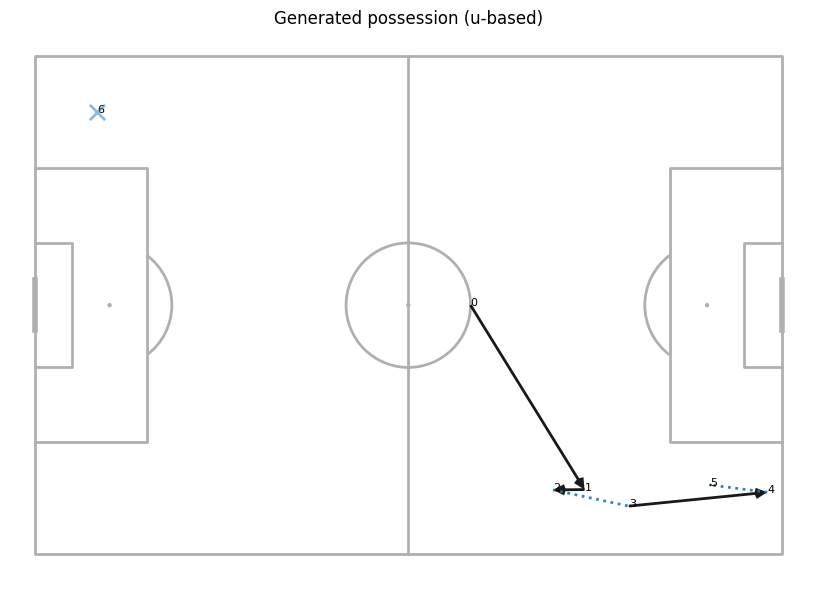

In [111]:
fig, ax = plot_sequence_from_u(seq, seed=0, title="Generated possession (u-based)")